In [1]:
import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
# import cv2
import os
import random
# from torch.autograd import Variable
# import tensorflow as tf
# import onnx
# from onnx_tf.backend import prepare

torch.cuda.empty_cache()
# random.seed(0)
# np.random.seed(0)
torch.manual_seed(0)

/home/frozenwolf/miniconda3/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/frozenwolf/miniconda3/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
model_name = "vit_tiny_patch16_224"
class ViTBase16(nn.Module):
    def __init__(self, n_classes):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model(model_name, pretrained=True)
        
        # self.transform  = T.Compose([
        #                                             T.ToTensor(),
        #                                             ])
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)


    def forward(self, x):
        x = self.model(x)
        return x


model = ViTBase16(2)

model.load_state_dict(torch.load("saved_models/vit_tiny_patch16_224", map_location='cuda'))

<All keys matched successfully>

In [6]:
transform  = T.Compose([T.Resize((224,224))
                                                    ])

def get_attention_map(img, get_mask=False):
    x = transform(img)
    # x = img
    x.size()

    logits, att_mat = model(x.unsqueeze(0))

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    # if get_mask:
    #     result = cv2.resize(mask / mask.max(), img.size)
    # else:        
    #     mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
    #     result = (mask * img).astype("uint8")
    
    # return result

def plot_attention_map(original_img, att_map):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map Last Layer')
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map)

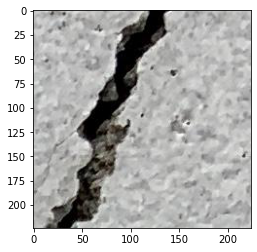

In [4]:
path = "surface_crack/train/Positive/IMG_0482_1_15.jpg"

img = Image.open(path)
# img = cv2.imread(path)[:,:,::-1]

plt.imshow(img)

In [7]:
ga = get_attention_map(img)
plot_attention_map(img, ga)


TypeError: 'tuple' object is not callable